## pix2pix

* task: image to image translation
* model: $G$ UNet like, $D$ patch GAN
* GAN's loss: LSGAN loss + L1Loss

In [2]:
import torch
from torch import nn
import torchvision

import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

import torchvision.transforms as transforms
from PIL import Image

from tqdm import tqdm
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("./../utils")
from utils import BasicConv, init_weight, set_seed, SEBlock, ResNetBlock
set_seed(2022)
%matplotlib inline


In [6]:
block = nn.ConvTranspose2d(5, 5, 4, 2, 1)
x = torch.randn(8, 5, 16, 16)
print(block(x).shape)


torch.Size([8, 5, 32, 32])


In [4]:
block = ResNetBlock(256, 3, 1, 1)
x = torch.randn(4, 256, 16, 16)
print(block(x).shape)

torch.Size([4, 256, 16, 16])


In [5]:
class StyleTransferModel(nn.Module):
    def __init__(self, img_channel=3, num_resblock=8) -> None:
        super(StyleTransferModel, self).__init__()
        self.head = nn.Sequential(
            nn.Conv2d(img_channel, 64, 7, 1, 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU(inplace=True)
        )

        reslayers = []
        for _ in range(num_resblock):
            reslayers.append(ResNetBlock(256, 3, 1, 1))
        self.res_layers = nn.Sequential(*reslayers)

        self.tail = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, img_channel, 7, 1, 3)
        )

        
    def forward(self, x):
        x = self.head(x)
        x = self.res_layers(x)
        x = self.tail(x)
        return x
def test_gen():
    model = StyleTransferModel()
    x = torch.rand(8, 3, 256, 256)
    print(f"model params num:{sum(p.numel() for p in model.parameters() if p.requires_grad==True)}")
    print(f"input size{x.shape}, output size: {model(x).shape}")
test_gen()

model params num:10198019
input sizetorch.Size([8, 3, 256, 256]), output size: torch.Size([8, 3, 256, 256])


## download dataset

In [3]:
! wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz && tar -xzf ./maps.tar.gz

--2022-04-08 12:49:13--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  5.10MB/s    in 58s     

2022-04-08 12:50:12 (4.09 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



## define models

### $G$'s model
   1. the UNet like skip connection is important for quality of generated image
   2. for efficience, i use seprable convolution in $G$

In [ ]:
class DoubleConv(nn.Module):
    """
    input: (N, dim, H, W)
    output: (N, dim, H, W)
    """
    def __init__(self, in_channel, out_channel, k_s, s, p) -> None:
        super(DoubleConv, self).__init__()
        layers = []
        layers.append(BasicConv(in_channel, out_channel, k_s, s, p))
        layers.append(BasicConv(out_channel, out_channel, k_s, s, p))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class Gen(nn.Module):
    """
    input: (N, 3, 256, 256)
    output: (N, 3, 256, 256)
    """
    def __init__(self, img_channel) -> None:
        super(Gen, self).__init__()
        
        self.down1_1 = DoubleConv(img_channel, 64, 3, 1, 1)
        self.down1_2 = nn.AvgPool2d(2, 2)

        self.down2_1 = DoubleConv(64, 128, 3, 1, 1)
        self.down2_2 = nn.AvgPool2d(2, 2)
        
        self.down3_1 = DoubleConv(128, 256, 3, 1, 1)
        self.down3_2 = nn.AvgPool2d(2, 2)
        

        self.bottleneck = DoubleConv(256, 512, 3, 1, 1)


        self.up1_1 = nn.ConvTranspose2d(512, 256, 2, 2, 0) 
        self.up1_2 = DoubleConv(512, 256, 3, 1, 1)

        self.up2_1 = nn.ConvTranspose2d(256, 128, 2, 2, 0) 
        self.up2_2 = DoubleConv(256, 128, 3, 1, 1)

        self.up3_1 = nn.ConvTranspose2d(128, 64, 2, 2, 0) 
        self.up3_2 = DoubleConv(128, 64, 3, 1, 1)

        self.final_conv = nn.Conv2d(64, img_channel, 1, 1, 0)
        
    def forward(self, x):
        d1 = self.down1_1(x)
        x = self.down1_2(d1)
        d2 = self.down2_1(x)
        x = self.down2_2(d2)
        d3 = self.down3_1(x)
        x = self.down3_2(d3)
        
        x= self.bottleneck(x)

        x = self.up1_2(torch.cat((self.up1_1(x),d3), dim=1))
        x = self.up2_2(torch.cat((self.up2_1(x),d2), dim=1))
        x = self.up3_2(torch.cat((self.up3_1(x),d1), dim=1))

        x = self.final_conv(x)
        return x

In [7]:
class DoubleConv(nn.Module):
    """
    input: (N, dim, H, W)
    output: (N, dim, H, W)
    """
    def __init__(self, in_channel, out_channel, k_s, s, p) -> None:
        super(DoubleConv, self).__init__()
        layers = []
        layers.append(BasicConv(in_channel, out_channel, k_s, s, p))
        layers.append(BasicConv(out_channel, out_channel, k_s, s, p))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class Gen(nn.Module):
    """
    input: (N, 3, 256, 256)
    output: (N, 3, 256, 256)
    """
    def __init__(self, img_channel) -> None:
        super(Gen, self).__init__()
        
        self.down1_1 = DoubleConv(img_channel, 64, 3, 1, 1)
        self.down1_2 = nn.AvgPool2d(2, 2)

        self.down2_1 = DoubleConv(64, 128, 3, 1, 1)
        self.down2_2 = nn.AvgPool2d(2, 2)
        
        self.down3_1 = DoubleConv(128, 256, 3, 1, 1)
        self.down3_2 = nn.AvgPool2d(2, 2)
        

        self.bottleneck = DoubleConv(256, 512, 3, 1, 1)


        self.up1_1 = nn.ConvTranspose2d(512, 256, 2, 2, 0) 
        self.up1_2 = DoubleConv(256, 256, 3, 1, 1)

        self.up2_1 = nn.ConvTranspose2d(256, 128, 2, 2, 0) 
        self.up2_2 = DoubleConv(128, 128, 3, 1, 1)

        self.up3_1 = nn.ConvTranspose2d(128, 64, 2, 2, 0) 
        self.up3_2 = DoubleConv(64, 64, 3, 1, 1)

        self.final_conv = nn.Conv2d(64, img_channel, 1, 1, 0)

    def forward(self, x):
        d1 = self.down1_1(x)
        x = self.down1_2(d1)
        d2 = self.down2_1(x)
        x = self.down2_2(d2)
        d3 = self.down3_1(x)
        x = self.down3_2(d3)
        
        x= self.bottleneck(x)

        x = self.up1_2(self.up1_1(x) + d3)
        x = self.up2_2(self.up2_1(x) + d2)
        x = self.up3_2(self.up3_1(x) + d1)

        x = self.final_conv(x)
        return x

In [8]:
def test_gen():
    model = Gen()
    x = torch.rand(8, 3, 256, 256)
    print(f"model params num:{sum(p.numel() for p in model.parameters() if p.requires_grad==True)}")
    print(f"input size{x.shape}, output size: {model(x).shape}")
test_gen()


model params num:6923331
input sizetorch.Size([8, 3, 256, 256]), output size: torch.Size([8, 3, 256, 256])


### $D$'s model
1. much like the D in DCGAN
2. because, pix2pix is supervised learning(training with paired data), so we need to send origin image and G's according output to D to constrain that: G must follow the basic structure of origin image.

In [4]:
class Disc(nn.Module):
    """
    input: (N, 6, 256, 256) x, y concated
    output: (N, 1, 8, 8)
    """
    def __init__(self, input_channel):
        super(Disc, self).__init__()
        main = []
        main .append(BasicConv(input_channel, 64, 5, 2, 1))
        main.append(BasicConv(64, 128, 3, 2, 1))
        main.append(BasicConv(128, 256, 3, 2, 1))
        main.append(BasicConv(256, 512, 3, 1, 1))
        main.append(nn.Conv2d(512, 1, 3, 1, 1))
        self.model = nn.Sequential(*main)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.model(x))
def test_disc():
    model = Disc(6)
    x = torch.rand(8, 6, 256, 256)
    print(f"model params num:{sum(p.numel() for p in model.parameters() if p.requires_grad==True)}")
    print(f"input size{x.shape}, output size: {model(x).shape}")
test_disc()

model params num:1563457
input sizetorch.Size([8, 6, 256, 256]), output size: torch.Size([8, 1, 32, 32])


In [5]:
LEARNING_RATE_GEN = 2e-4
LEARNING_RATE_DISC = 2e-4
NUM_EPOCH = 15
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
class MapDataset(Dataset):
    def __init__(self, path, transform, train) -> None:
        self.path = path
        self.img_lst = os.listdir(self.path)
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(f"{self.path}{self.img_lst[idx]}")
        if self.transform:
          img = self.transform(img)
        x = img[:, :, :256]
        y = img[:, :, 256:]
        return x, y

    def __len__(self):
        return len(self.img_lst)



In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor()
])
train_dataset = MapDataset('./maps/train/', transform, True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = MapDataset('./maps/val/', transform, True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
fix_val_samples_x, fix_val_samples_y = next(iter(valid_dataloader))
valid_x_grid = torchvision.utils.make_grid(fix_val_samples_x, nrow=4)
valid_y_grid = torchvision.utils.make_grid(fix_val_samples_y, nrow=4)

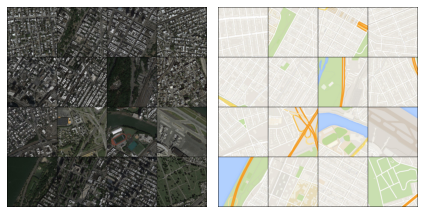

In [8]:
train_x, train_y = next(iter(train_dataloader))
x_grid = torchvision.utils.make_grid(train_x[:16], nrow=4)
y_grid = torchvision.utils.make_grid(train_y[:16], nrow=4)
plt.subplot(1,2,1)
plt.imshow(x_grid.permute(1,2,0).numpy())
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(y_grid.permute(1,2,0).numpy())
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
gen = Gen(3).to(DEVICE)
disc = Disc(6).to(DEVICE)

gen.apply(init_weight)
disc.apply(init_weight)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE_GEN, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE_DISC, betas=(0.5, 0.999))

gan_criterion = nn.MSELoss()
l1 = nn.L1Loss()

  0%|          | 0/18 [00:00<?, ?it/s]

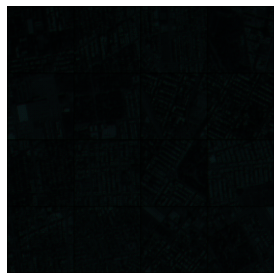

 28%|██▊       | 5/18 [00:21<00:55,  4.25s/it]

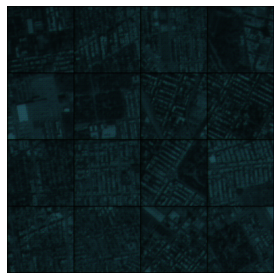

 56%|█████▌    | 10/18 [00:43<00:34,  4.29s/it]

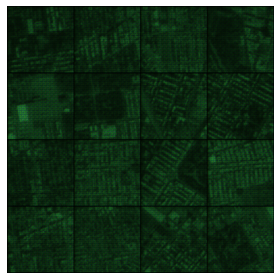

 83%|████████▎ | 15/18 [01:04<00:12,  4.23s/it]

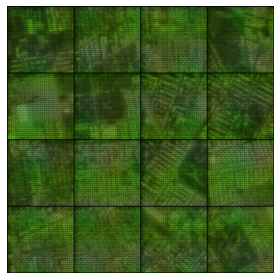

  0%|          | 0/18 [00:00<?, ?it/s]

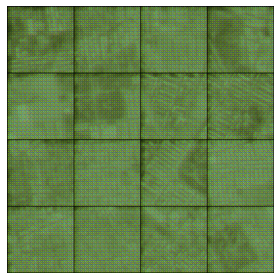

 28%|██▊       | 5/18 [00:21<00:55,  4.24s/it]

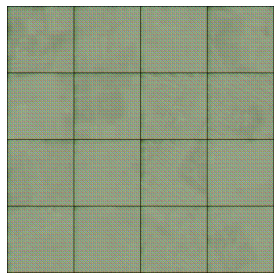

 56%|█████▌    | 10/18 [00:43<00:33,  4.23s/it]

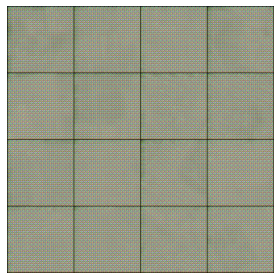

 83%|████████▎ | 15/18 [01:04<00:12,  4.22s/it]

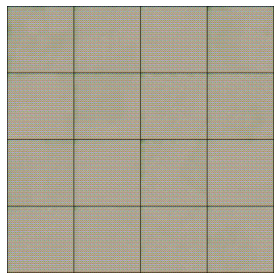

  0%|          | 0/18 [00:00<?, ?it/s]

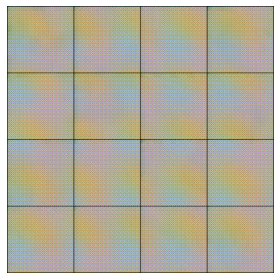

 28%|██▊       | 5/18 [00:21<00:54,  4.22s/it]

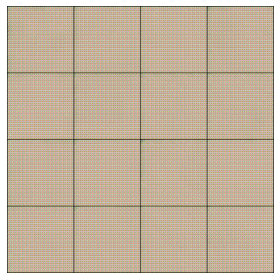

 39%|███▉      | 7/18 [00:33<00:52,  4.74s/it]


KeyboardInterrupt: ignored

In [13]:
for epoch in range(NUM_EPOCH):
    loop = tqdm(train_dataloader, leave=True)
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        gen.train()
        disc.train()
        
        # generate fake img and disc it
        fake_gen = gen(x)
        fake_disc = disc(torch.cat((x, fake_gen), dim=1))
        fake_disc_loss = gan_criterion(fake_disc, torch.zeros_like(fake_disc).to(DEVICE))
        # disc real pairs
        real_disc = disc(torch.cat((x, y), dim=1))
        real_disc_loss = gan_criterion(real_disc, torch.ones_like(real_disc).to(DEVICE))

        disc_loss = (fake_disc_loss + real_disc_loss)/2
        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # G's GAN loss
        fake_gen = gen(x)
        fake_disc = disc(torch.cat((x, fake_gen), dim=1))
        gen_gan_loss = gan_criterion(fake_disc, torch.ones_like(fake_disc).to(DEVICE))
        # G's L1Loss
        # gen_l1_loss = l1(fake_gen, y)
        gen_loss = gen_gan_loss
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()



        if batch_idx % 5 == 0:
          gen.eval()
          disc.eval()
          # GAN sample real and gen_result
          with torch.no_grad():
            fake_out = gen(fix_val_samples_x.to(DEVICE))
            fake_out_grid = torchvision.utils.make_grid(fake_out, nrow=4)
            plt.imshow(fake_out_grid.cpu().permute(1,2,0).numpy())
            plt.axis("off")
            plt.tight_layout()
            plt.show()


